# Import modules

In [78]:
import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.layers import BatchNormalization
from keras.layers.recurrent import LSTM, GRU
from keras.models import load_model
from keras import regularizers
from keras.callbacks import EarlyStopping
from keras import backend as K
import keras
import math
from sklearn.preprocessing import RobustScaler
import matplotlib.pyplot as plt
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV
import seaborn as sns
%matplotlib inline

# To check whether Keras is using GPU

In [2]:
from keras import backend as K
K.get_session().list_devices()

[_DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 2255760221760),
 _DeviceAttributes(/job:localhost/replica:0/task:0/device:GPU:0, GPU, 2255760221648)]

# Import the CSV file with technical data and sentiment analysis

In [3]:
data = pd.read_pickle('Final_df.pkl')
data.index = pd.to_datetime(data.index, format='%Y-%m-%d')
data['Y'] = data.lrets.shift(-1)
data.dropna(axis=0, inplace=True)
data.head()

,Adj Close,Volume,lrets,MACD,stochastics,ATR,neg,neu,pos,Y
1990-01-02,359.690002,162070000.0,0.017642,1.018527,100.000000,7.709991,0.081,0.856,0.063,-0.002589
1990-01-03,358.760010,192330000.0,-0.002589,1.392774,94.602487,2.699981,0.077,0.870,0.053,-0.008650
1990-01-04,355.670013,177000000.0,-0.008650,1.377343,76.668680,5.869995,0.092,0.839,0.069,-0.009804
1990-01-05,352.200012,158530000.0,-0.009804,1.058777,56.529395,4.320007,0.147,0.755,0.098,0.004504
1990-01-08,353.790009,140110000.0,0.004504,0.898704,65.757462,3.699981,0.079,0.858,0.063,-0.011857


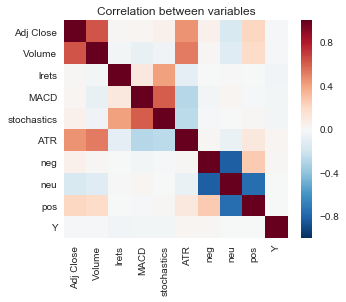

In [79]:
corr = data.corr()
f, ax = plt.subplots(figsize=(5, 4))
plt.title("Correlation between variables")
sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)

# Train Test split for recurrent neural net

In [4]:
def load_data(stock, seq_len, split):
    amount_of_features = len(stock.columns)
    data = stock.values
    sequence_length = seq_len + 1 # index starting from 0
    result = []
    
    # This will cause data leakge problem
    scaler = RobustScaler()
    data = scaler.fit_transform(data)
    
    for index in range(len(data) - sequence_length): # row - seq_len
        result.append(data[index: index + sequence_length]) # result.append(day i to day i + 22)  
    
    result = np.array(result)
    
    row = round(split * result.shape[0])
    train = result[:int(row), :]
    X_train = train[:, :, :-1] 
    y_train = train[:, :, -1][:, -1]
    
    X_test = result[int(row):, :, :-1]
    y_test = result[int(row):, :, -1][:, -1]
    
   # X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], amount_of_features))
   # X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], amount_of_features))  

    return [X_train, y_train, X_test, y_test]

# Hyperparameters

In [34]:
amount_of_features = len(data.columns)
seq_len= 21
split = 0.8
layers = [seq_len, 10]
d = 0.2 # Fraction of the input units to drop
epochs = 100

In [35]:
X_train, y_train, X_test, y_test = load_data(data, seq_len, split)

In [36]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((5120, 22, 9), (5120,), (1280, 22, 9), (1280,))

# Build up GRU model

- Adam Optimizer = RMSProp + Momentum

- RMSE should be more useful when large errors are particularly undesirable.

- We will use L2 regularization to avoid overfitting.

- L1 regularization helps perform feature selection in sparse feature spaces, and that is a good practical reason to use L1 in some situations. However, beyond that particular reason I have never seen L1 to perform better than L2 in practice. 


- BatchNormalization for optimization
- Dropout for regularization
- https://www.quora.com/What-is-the-difference-between-dropout-and-batch-normalization

In [65]:
def r2_keras(y_true, y_pred):
    SS_res =  K.sum(K.square(y_true - y_pred)) 
    SS_tot = K.sum(K.square(y_true - K.mean(y_true))) 
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

callbacks_list = [EarlyStopping(monitor='val_loss', patience=10, min_delta=0.00001, verbose=1)]

In [66]:
def build_model(layers, d):
        model = Sequential()
        
        model.add(GRU(2048, input_shape=(layers[0]+1, layers[1]-1), return_sequences=True))
        model.add(GRU(1024, return_sequences=True))
        model.add(GRU(512, return_sequences=False))       
        
        model.add(Dense(256, activation='relu'))#,kernel_regularizer=regularizers.l2()))
        model.add(Dropout(d))
        model.add(BatchNormalization())
        
        model.add(Dense(128, activation='relu'))
        model.add(Dense(1, activation='linear'))
        
        model.compile(loss='mse',optimizer='adam',metrics=[r2_keras])
        return model

In [67]:
model = build_model([seq_len, amount_of_features], d)

In [68]:
model.fit(
    X_train,
    y_train,
    batch_size=512, # Using mini-batch gradient descent
    epochs=epochs, # Doesn't matter because we are using early stopping
    validation_split=0.1,
    verbose=1,
    callbacks = callbacks_list)

Train on 4608 samples, validate on 512 samples
Epoch 1/100
4608/4608 [==============================] - 11s - loss: 2.8321 - r2_keras: -1.2480 - val_loss: 1.6068 - val_r2_keras: -0.1961
Epoch 2/100
4608/4608 [==============================] - 7s - loss: 1.5296 - r2_keras: -0.2015 - val_loss: 1.7400 - val_r2_keras: -0.2952
Epoch 3/100
4608/4608 [==============================] - 7s - loss: 1.4521 - r2_keras: -0.1386 - val_loss: 1.6835 - val_r2_keras: -0.2531
Epoch 4/100
4608/4608 [==============================] - 7s - loss: 1.4332 - r2_keras: -0.1258 - val_loss: 1.5193 - val_r2_keras: -0.1309
Epoch 5/100
4608/4608 [==============================] - 7s - loss: 1.3873 - r2_keras: -0.0909 - val_loss: 1.4467 - val_r2_keras: -0.0769
Epoch 6/100
4608/4608 [==============================] - 7s - loss: 1.3765 - r2_keras: -0.0806 - val_loss: 1.4086 - val_r2_keras: -0.0486
Epoch 7/100
4608/4608 [==============================] - 7s - loss: 1.3763 - r2_keras: -0.0790 - val_loss: 1.3972 - val_r2_k

# Hyperparameters fine tuning log

Since the batch size of training data is smaller than that of testing data, the test score should be larger than the train score.

Baseline model: 3GRU (relu) + 3Layers, BatchNormalization + Dropout 

    R squared: -0.173668482448
    Train Score: 1.35 MSE (1.16 RMSE)
    Test Score: 0.73 MSE (0.85 RMSE)


LSTM vs GRU (x)

The performance of GRU is on par with LSTM, but computationally more efficient https://datascience.stackexchange.com/questions/14581/when-to-use-gru-over-lstm

    LSTM: -0.000320206218271 (Not activated)
    Train Score: 1.29 MSE (1.13 RMSE)
    Test Score: 0.62 MSE (0.79 RMSE)

    GRU: -0.173668482448
    Train Score: 1.35 MSE (1.16 RMSE)
    Test Score: 0.73 MSE (0.85 RMSE)


BatchNormalization vs BatchNormalization + Dropout (x)

    BatchNormalization only: -0.00960587786743
    Train Score: 1.21 MSE (1.10 RMSE)
    Test Score: 0.63 MSE (0.79 RMSE)

    BatchNormalization + Dropout: -0.173668482448
    Train Score: 1.35 MSE (1.16 RMSE)
    Test Score: 0.73 MSE (0.85 RMSE)
    
    
Normal vs An extra layer: (x)

    Normal: -0.173668482448
    Train Score: 1.35 MSE (1.16 RMSE)
    Test Score: 0.73 MSE (0.85 RMSE)
    
    Extra layer: -0.0992312116596
    Train Score: 1.31 MSE (1.15 RMSE)
    Test Score: 0.68 MSE (0.83 RMSE)
    
    
Linear vs Tanh vs Relu for the last layer:
    
    Linear: -0.173668482448
    Train Score: 1.35 MSE (1.16 RMSE)
    Test Score: 0.73 MSE (0.85 RMSE)
    
    Tanh:
    Train Score: 1.30 MSE (1.14 RMSE)
    Test Score: 0.68 MSE (0.82 RMSE)
    
    Relu (Never activated):
    Train Score: 1.29 MSE (1.13 RMSE)
    Test Score: 0.62 MSE (0.79 RMSE)
    
Tanh GRU vs Relu GRU:
    
    Tanh: -0.199709876165
    Train Score: 1.33 MSE (1.15 RMSE)
    Test Score: 0.74 MSE (0.86 RMSE)
    
    Relu GRU: -0.0166898549691
    Train Score: 1.29 MSE (1.14 RMSE)
    Test Score: 0.63 MSE (0.79 RMSE)

In [74]:
trainScore = model.evaluate(X_train, y_train, verbose=0)
print('RMSE: %2f' % math.sqrt(trainScore[0]), 'R2 : %2f' % trainScore[1])

testScore = model.evaluate(X_test, y_test, verbose=0)
print('RMSE: %2f'% math.sqrt(testScore[0]), 'R2 : %2f' % testScore[1])

RMSE: 1.137353 R2 : -0.040260
RMSE: 0.803628 R2 : -0.101986


# Using R squared to see if this model really can predict

In [75]:
p = model.predict(X_test)

If the chosen model fits worse than a horizontal line, then R2 is negative.

# Plotting Predicted value vs True value

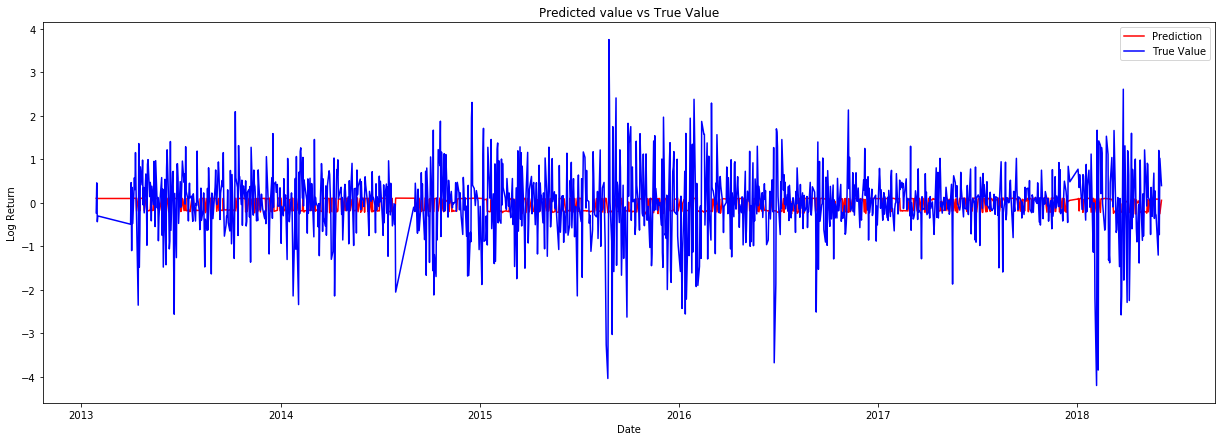

In [76]:
plt.figure(figsize=(21,7))
plt.plot(data.index[-len(p):], p,color='red', label='Prediction')
plt.plot(data.index[-len(y_test):], y_test,color='blue', label='True Value')
plt.xlabel("Date")
plt.ylabel("Log Return")
plt.title('Predicted value vs True Value')
plt.legend(loc='best')
plt.show()

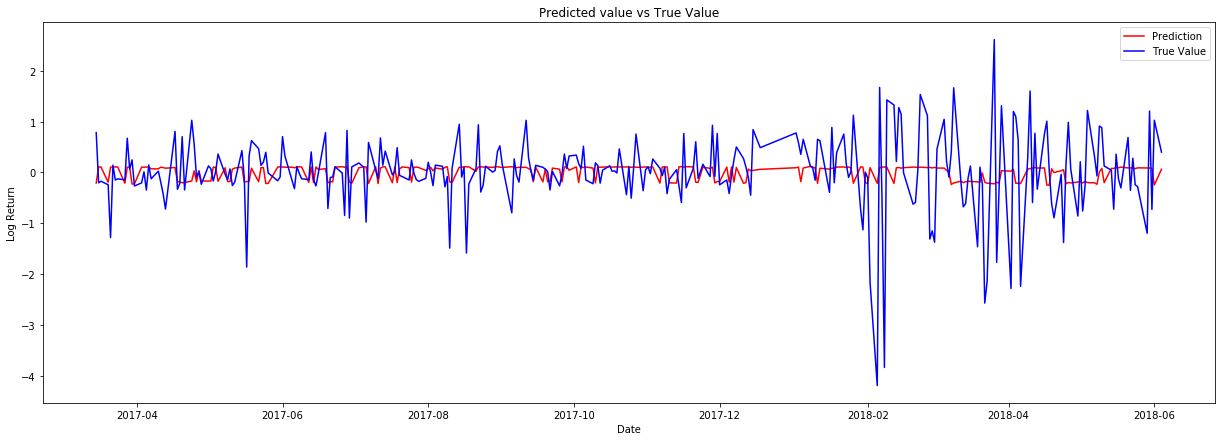

In [77]:
plt.figure(figsize=(21,7))
plt.plot(data.index[-300:], p[-300:], color='red', label='Prediction')
plt.plot(data.index[-300:], y_test[-300:], color='blue', label='True Value')
plt.xlabel("Date")
plt.ylabel("Log Return")
plt.title('Predicted value vs True Value')
plt.legend(loc='best')
plt.show()

Seems like for both model, the prediction is not good enough and maybe it's better to use classification function

# Clear the model to avoid MemoryExhaustion

In [59]:
K.clear_session()

In [48]:
# Using RNN for classification